In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hyperion.model import ModelOutput
from astropy.cosmology import Planck15
from astropy import units as u
from astropy import constants
import sys, os, glob
import pandas as pd

np.set_printoptions(precision=2)

In [4]:
#========================================================

#z = 0.0249 --> right now, snap305 is redshift 0
z = 0.0
run = sysargv[1] + sysargv[2]


#========================================================

In [21]:
m = ModelOutput(run)
wav,flux = m.get_sed(inclination='all',aperture=-1)

wav  = np.asarray(wav)*u.micron #wav is in micron
wav *= (1.+z)

flux = np.asarray(flux)*u.erg/u.s
dl = 10.0*u.pc
dl = dl.to(u.cm)

    
flux /= (4.*3.14*dl**2.)
    
nu = constants.c.cgs/(wav.to(u.cm))
nu = nu.to(u.Hz)

flux /= nu
flux = flux.to(u.mJy)


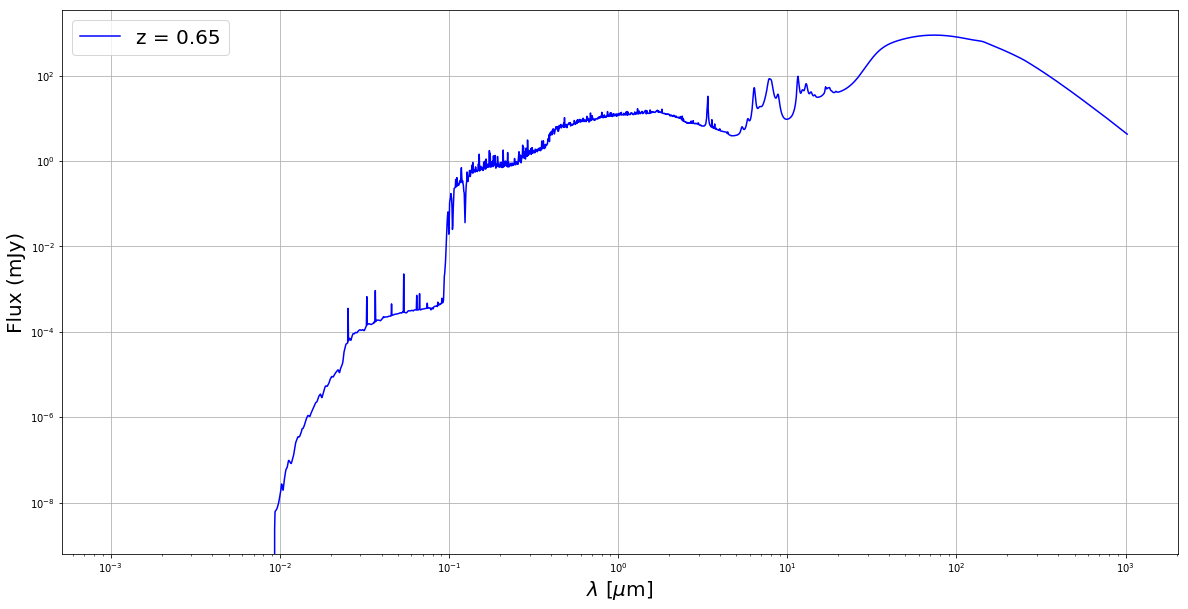

In [22]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)
for i in range(flux.shape[0]):
    ax.loglog(wav,flux[i,:], c='blue', label='z = 0.65')

ax.set_xlabel(r'$\lambda$ [$\mu$m]', fontsize=20)
ax.set_ylabel('Flux (mJy)', fontsize=20)
#ax.set_ylim([1e-1,1e8])
#ax.set_xlim(0.05,1e3)
ax.grid()
ax.legend(loc='upper left', fontsize=20)

In [23]:
#make a CIGALE readable csv from the fluxes @ different filter positions
#error will be 5-10% of flux

filter_wavs = np.array([.15, .23, .475, .606, .814, 22., 70., 100., 160., 250., 350., 500.]) #um
flx = [None] * len(filter_wavs)
flxe = [None] * len(filter_wavs)
for i in range(0, len(filter_wavs)):
    flx[i] = flux[0][(np.abs(wav.value - filter_wavs[i])).argmin()].value
    flxe[i] = np.random.uniform(low=0.05, high=0.1, size=None) * flx[i]
flx = np.asarray(flx)
flxe = np.asarray(flxe)

In [24]:
phot = np.insert(flxe, np.arange(len(flx)), flx)

In [25]:
#header info
filter_names = ['galex.FUV', 'galex.FUV_err', 'galex.NUV', 'galex.NUV_err', 'wfc3_uvis_f475w', 'wfc3_uvis_f475w_err',
                'wfc3_uvis_f606w', 'wfc3_uvis_f606w_err', 'wfc3_uvis_f814w', 'wfc3_uvis_f814w_err', 'wise_w4', 
                'wise_w4_err','herschel_pacs_70', 'herschel_pacs_70_err', 'herschel_pacs_100', 'herschel_pacs_100_err', 
                'herschel_pacs_160', 'herschel_pacs_160_err', 'herschel_spire_250', 'herschel_spire_250_err', 'herschel_spire_350',
               'herschel_spire_350_err', 'herschel_spire_500', 'herschel_spire_500_err']

id_ = str(os.path.splitext(sys.argv[2])[0])

redshift = z

In [26]:
line1 = ['id']
line1.extend(filter_names)
line2 = [id_]
line2.extend(phot)
dat = np.stack((line1, line2))

In [27]:
np.savetxt(sys.argv[1]+id_, dat, delimiter=",", fmt="%s") 